# Evaluation of SBMV for structured references

Dominika Tkaczyk

5.05.2019

This analysis contains the evaluation of the search-based matching algorithms for structured references.

## Methodology

The test dataset is composed of 2,000 randomly chosen structured references. Three algorithms are compared:
  * the legacy approach (OpenURL)
  * Search-Based Matching
  * Search-Based Matching with Validation

## Results

In [1]:
import sys
sys.path.append('../..')

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import re
import utils.data_format_keys as dfk

from dataset.dataset_utils import get_target_test_doi, get_target_gt_doi
from evaluation.link_metrics import LinkMetricsResults
from scipy.stats import chi2_contingency
from utils.utils import read_json
from utils.cr_utils import generate_unstructured

DATA_DIR = 'data/'

Read the datasets:

In [2]:
dataset_ou = read_json(DATA_DIR + 'dataset_ou.json')[dfk.DATASET_DATASET]
dataset_sbm = read_json(DATA_DIR + 'dataset_sbm.json')[dfk.DATASET_DATASET]
dataset_sbmv = read_json(DATA_DIR + 'dataset_sbmv.json')[dfk.DATASET_DATASET]
print('Dataset size: {}'.format(len(dataset_sbm)))

Dataset size: 2000


This function modifies the dataset according to the threshold:

In [3]:
def modify_validation_threshold(dataset, threshold):
    for item in dataset:
        if item[dfk.DATASET_SCORE] is not None and item[dfk.DATASET_SCORE] < threshold:
            item[dfk.DATASET_TARGET_TEST][dfk.CR_ITEM_DOI] = None
    return dataset

def modify_relevance_threshold(dataset, threshold):
    for item in dataset:
        if item[dfk.DATASET_SCORE] is not None \
            and item[dfk.DATASET_SCORE]/len(generate_unstructured(item[dfk.DATASET_REFERENCE])) < threshold:
            item[dfk.DATASET_TARGET_TEST][dfk.CR_ITEM_DOI] = None
    return dataset

Let's calculate SBM's and SBMV's results for different thresholds:

In [4]:
dataset_sbm = modify_relevance_threshold(dataset_sbm, 0.46)
dataset_sbmv = modify_validation_threshold(dataset_sbmv, 0.78)

The results of OpenURL:

In [5]:
def print_summary(dataset, name):
    link_results = LinkMetricsResults(dataset)
    print('{} precision: {:.4f} (CI at 95% {:.4f}-{:.4f})'
          .format(name, link_results.get(dfk.EVAL_PREC),
                  link_results.get(dfk.EVAL_CI_PREC)[0], link_results.get(dfk.EVAL_CI_PREC)[1]))
    print('{} recall: {:.4f} (CI at 95% {:.4f}-{:.4f})'
          .format(name, link_results.get(dfk.EVAL_REC),
                  link_results.get(dfk.EVAL_CI_REC)[0], link_results.get(dfk.EVAL_CI_REC)[1]))
    print('{} F1: {:.4f}'.format(name, link_results.get(dfk.EVAL_F1)))

print_summary(dataset_ou, 'OpenURL')

OpenURL precision: 0.9516 (CI at 95% 0.9397-0.9634)
OpenURL recall: 0.9244 (CI at 95% 0.9101-0.9388)
OpenURL F1: 0.9378


The results of SBM:

In [6]:
print_summary(dataset_sbm, 'SBM')

SBM precision: 0.6304 (CI at 95% 0.6080-0.6528)
SBM recall: 0.8666 (CI at 95% 0.8481-0.8851)
SBM F1: 0.7299


The results of SBMV:

In [7]:
print_summary(dataset_sbmv, 'SBMV')

SBMV precision: 0.9446 (CI at 95% 0.9321-0.9570)
SBMV recall: 0.9460 (CI at 95% 0.9337-0.9583)
SBMV F1: 0.9453


Let's use a statistical test to check whether the differences in precision and recall between the legacy approach and SBMV are statistically significant:

In [8]:
for metric in [dfk.EVAL_PREC, dfk.EVAL_REC]:
    fun = get_target_test_doi if metric == dfk.EVAL_PREC else get_target_gt_doi
    ou_results = LinkMetricsResults(dataset_ou)
    ou_precision = ou_results.get(metric)
    ou_test_count = len([d for d in dataset_ou if fun(d) is not None])
    ou_precision_success = int(ou_precision * ou_test_count)

    sbmv_results = LinkMetricsResults(dataset_sbmv)
    sbmv_precision = sbmv_results.get(metric)
    sbmv_test_count = len([d for d in dataset_sbmv if fun(d) is not None])
    sbmv_precision_success = int(sbmv_precision * sbmv_test_count)

    _, p, _, _ = chi2_contingency(np.array([[ou_precision_success,
                                             ou_test_count-ou_precision_success],
                                           [sbmv_precision_success,
                                            sbmv_test_count-sbmv_precision_success]]),
                                  correction=True)
    c = 'this is statistically significant' if p < 0.05 \
        else 'this is not statistically significant'
    print('{} p-value: {:.4f} ({})'.format(metric, p, c))

precision p-value: 0.4776 (this is not statistically significant)
recall p-value: 0.0312 (this is statistically significant)


Let's compare the algorithms in one plot:

In [9]:
def get_means(dataset):
    results = LinkMetricsResults(dataset)
    return [results.get(m) for m in [dfk.EVAL_PREC, dfk.EVAL_REC, dfk.EVAL_F1]]

def get_ci(dataset):
    results = LinkMetricsResults(dataset)
    ms = [results.get(m) for m in [dfk.EVAL_PREC, dfk.EVAL_REC]]
    return [[a-results.get(m)[0] for m, a in zip([dfk.EVAL_CI_PREC, dfk.EVAL_CI_REC], ms)] + [0],
            [results.get(m)[1]-a for m, a in zip([dfk.EVAL_CI_PREC, dfk.EVAL_CI_REC], ms)] + [0]]

def autolabel(ax, rects):
    plt.rcParams.update({'font.size': 14})
    for rect in rects:
        height = rect.get_height()
        text = '{:.2f}'.format(height)
        text = re.sub('\.00$', '', text)
        ax.text(rect.get_x() + rect.get_width()/2., 1.04*height, text, ha='center', va='bottom')

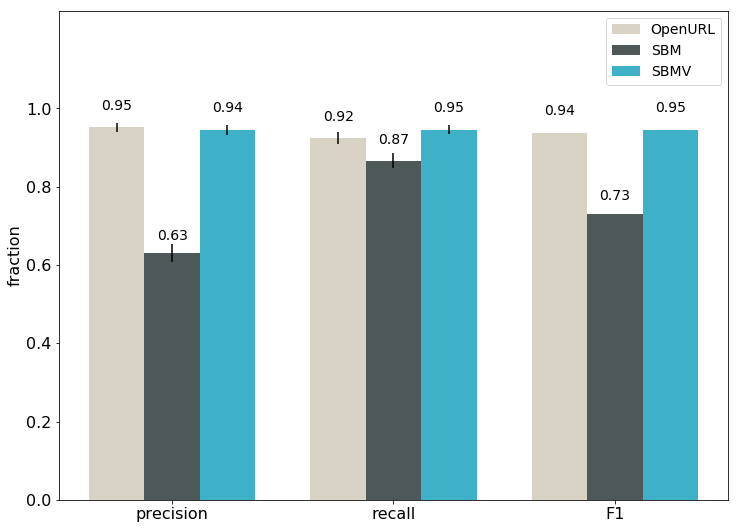

In [10]:
ind = np.arange(3)
width = 0.25
plt.rcParams.update({'font.size': 16, 'legend.fontsize': 14}) 
fig, ax = plt.subplots(figsize=(12, 9))

rects1 = ax.bar(ind - 0.5 * width, get_means(dataset_ou), yerr=get_ci(dataset_ou), width=width,
                color='#d8d2c4')
rects2 = ax.bar(ind + 0.5 * width, get_means(dataset_sbm), yerr=get_ci(dataset_sbm),
                width=width, color='#4f5858')
rects3 = ax.bar(ind + 1.5 * width, get_means(dataset_sbmv), yerr=get_ci(dataset_sbmv),
                width=width, color='#3eb1c8')

ax.set_ylabel('fraction')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('precision', 'recall', 'F1'))
plt.ylim(0, 1.25)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.legend((rects1[0], rects2[0], rects3[0]), ('OpenURL', 'SBM', 'SBMV'))
autolabel(ax, rects1)
autolabel(ax, rects2)
autolabel(ax, rects3)

plt.show() 